# **ATS Computer Vision/RE604**




Nama : Yudhistira Prasetyo Adios

NIM : 4222201058

Kelas : Robotika-B Pagi

## **IMPORT DATA**

Improt Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Read data

In [ ]:
df = pd.read_csv("emnist-letters-train.csv", header=None)

See multiple rows and columns

In [ ]:
print(df.shape)

(40690, 785)


Shuffle data

In [ ]:
df = shuffle(df, random_state=42).reset_index(drop=True)

Separate labels and features

In [ ]:
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.reshape(-1, 28, 28)

Change labels

In [ ]:
#from 1-26 to A-Z
label_map = {i: chr(64 + i) for i in range(1, 27)}
labels_char = np.array([label_map[label] for label in labels])

Visualization 1 row 5 columns

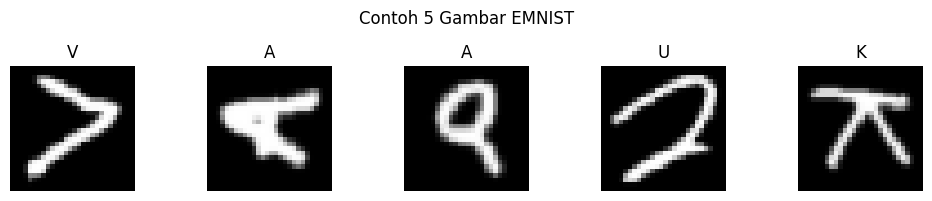

In [ ]:
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels_char[i])
    plt.axis('off')
plt.suptitle("Contoh 5 Gambar EMNIST")
plt.tight_layout()
plt.show()

Selecting a Balanced Subset (100 Samples per Letter)


In [ ]:
selected_indices = []
for label in range(1, 27):
    idx = np.where(labels == label)[0][:100]
    selected_indices.extend(idx)

selected_images = images[selected_indices]
selected_labels = labels[selected_indices]
selected_labels_char = labels_char[selected_indices]

## **HOG Feature Extraction**

In [ ]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

hog_features = []
for img in selected_images:
    feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), block_norm='L2-Hys')
    hog_features.append(feature)

hog_features = np.array(hog_features)


Scaler

In [ ]:
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_features)

## **SVM + Grid Search**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_scaled, selected_labels, test_size=0.2, random_state=42, stratify=selected_labels)

In [ ]:
param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.01],
    'kernel': ['rbf']
}

clf = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy', cv=3)
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


## **Evaluation LOOCV**

Setup and best model

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import seaborn as sns
import time

if not hasattr(clf, "best_params_"):
    raise ValueError("GridSearchCV (clf) belum di-fit. Jalankan clf.fit(X_train, y_train) dulu.")

best_svm = svm.SVC(
    C=clf.best_params_['C'],
    gamma=clf.best_params_['gamma'],
    kernel=clf.best_params_['kernel']
)

LOOCV will carry out 390 training sessions

In [ ]:
sample_indices = []
for label in range(1, 27):
    idx = np.where(selected_labels == label)[0][:15]
    sample_indices.extend(idx)

X_loo = hog_scaled[sample_indices]
y_loo = selected_labels[sample_indices]

Run LOOCV

In [ ]:
loo = LeaveOneOut()
y_true_loo = []
y_pred_loo = []

loo = LeaveOneOut()
start_time = time.time()
for train_idx, test_idx in loo.split(X_loo):
    X_tr, X_te = X_loo[train_idx], X_loo[test_idx]
    y_tr, y_te = y_loo[train_idx], y_loo[test_idx]

    best_svm.fit(X_tr, y_tr)
    pred = best_svm.predict(X_te)

    y_true_loo.append(y_te[0])
    y_pred_loo.append(pred[0])
end_time = time.time()

Final Evaluation

In [ ]:
# Evaluasi akhir
print("LOOCV Evaluation (520 samples):")
print(f"Accuracy : {accuracy_score(y_true_loo, y_pred_loo):.4f}")
print(f"Precision: {precision_score(y_true_loo, y_pred_loo, average='macro', zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_true_loo, y_pred_loo, average='macro', zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_true_loo, y_pred_loo, average='macro', zero_division=0):.4f}")
print(f"Execution Time: {end_time - start_time:.2f} seconds\n")


LOOCV Evaluation (520 samples):
Accuracy : 0.6712
Precision: 0.6811
Recall   : 0.6712
F1 Score : 0.6720
Execution Time: 34.10 seconds



Confussion matrix

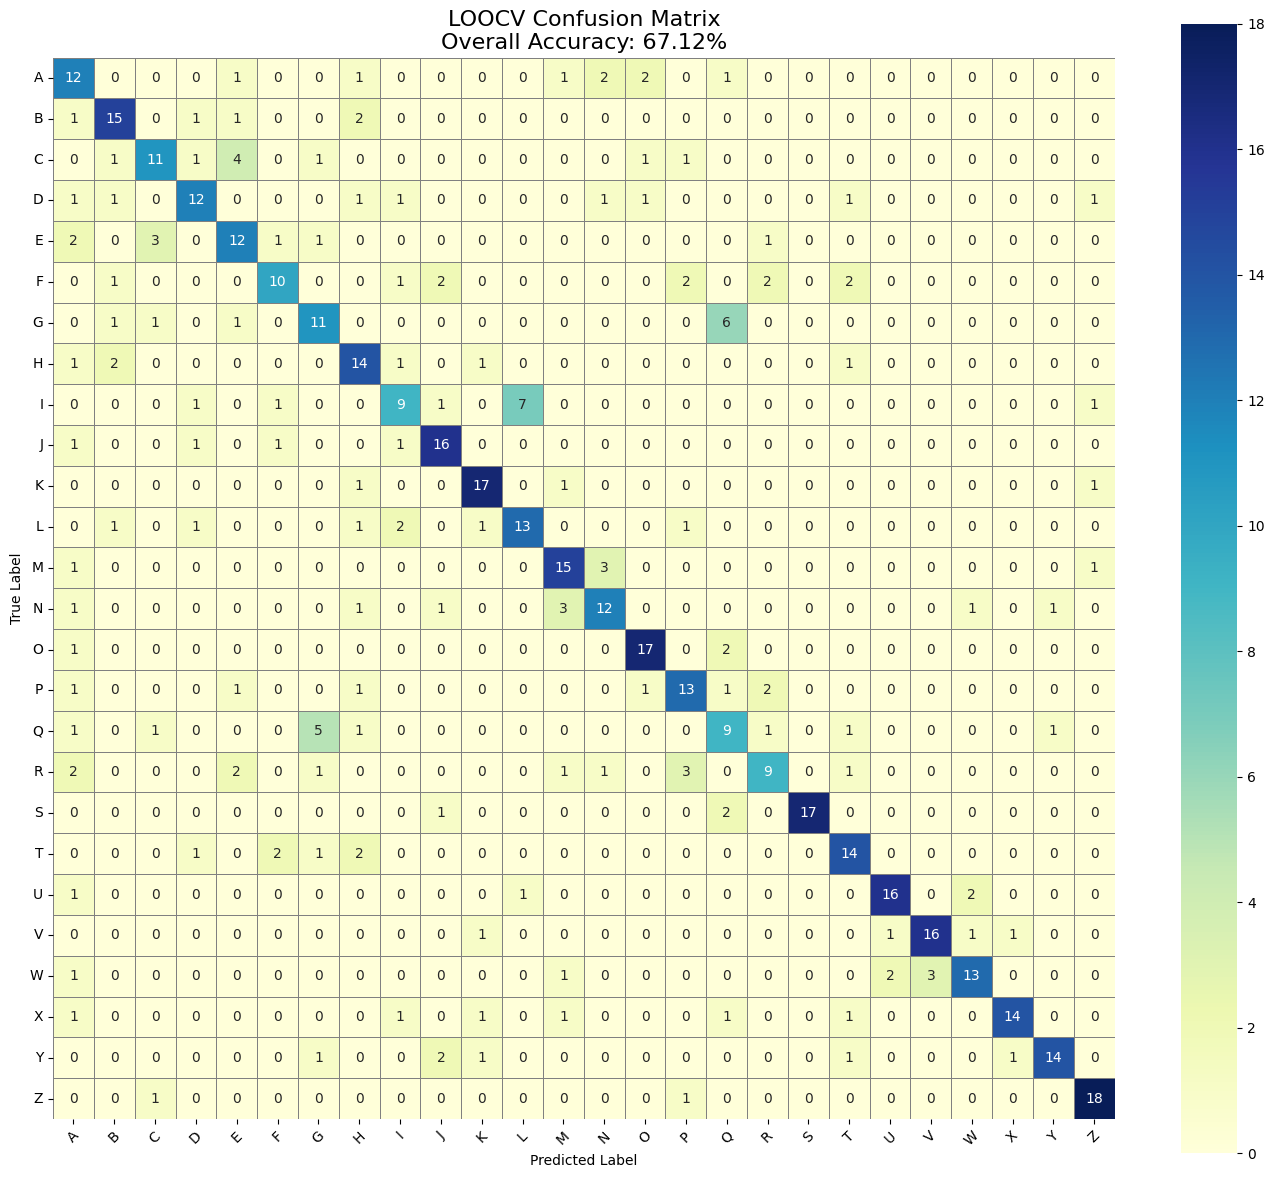

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_loo, y_pred_loo)
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=labels, yticklabels=labels, cbar=True,
            linewidths=0.5, linecolor='gray', square=True)

acc = accuracy_score(y_true_loo, y_pred_loo)
plt.title(f"LOOCV Confusion Matrix\nOverall Accuracy: {acc:.2%}", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()